# STOCHASTIC CLIMATE EMULATORS FOR COASTAL HAZARDS
### UCSC - Nov 2024


<img src="images/Image_3.png" alt="Texto alternativo" width="400">  

## TESLA: 04 - MADDEN-JULIAN OSCILATION (MJO) INTRA-SEASONAL WEATHER TYPES (IWT) AUTOREGRESSIVE LOGISTIC REGRESSION MODEL (ALR)



---

Fernando J.Mendez (fernando.mendez@unican.es)

Full Profesor at the Univeristy of Cantabria

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, University of Cantabria

<img src="images/Image_1.png" alt="Texto alternativo" width="200">               <img src="images/Image_2.jpeg" alt="Texto alternativo" width="200">

<img src="images/Image_4.jpeg" alt="Texto alternativo" width="800"> 

© GeoOcean 2024 - University of Cantabria


---

**Obtain Intraseasonal Weather Types (IWT, at daily scale) following the methodology explained in Anderson et al. (2019)**

Inputs required:
  * Daily values of Madden-Julian Oscillation (MJO) parameters (rmm1, rmm2, phase, mjo)
  
In this notebook:
  1. Import required libraries and paths
  2. Obtain MJO categories (25) based on rmm1, rmm2, and phase
  3. Fit the autoregressive logistic model with a markov order 3 and seasonality
  4. Time-series simulation of *n* simulations of 1000 years of the 25 categories
  5. Randomly obtain pairs of rmm1, rmm2 and phase from the simulated time-series
  6. Validation


---

## **1. Import required libraries and paths**

In [1]:
import warnings
warnings.filterwarnings('ignore')

# system
import os
import os.path as op
from datetime import date, timedelta, datetime

import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr

# matlab files
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta, datetime

In [2]:
# teslakit
from bluemath_tk.teslakit2.wts.mjo import categories
from bluemath_tk.teslakit2.toolkit.alr import ALR_WRP
from bluemath_tk.teslakit2.util.operations import GetRepeatedValues
from bluemath_tk.teslakit2.io.aux import save_nc
from bluemath_tk.teslakit2.plotting.mjo import Plot_MJO_phases, Plot_MJO_Categories

In [3]:
# paths
p_dat = ('/workspaces/TESLA_UCSC/data')
p_out = ('/workspaces/TESLA_UCSC/results')

pcs_awt = xr.open_dataset(op.join(p_out, 'AWT_PCs_from_DWT.nc'))
p_alr_awt = op.join(p_out, 'awt_alr')

---

## **2. OBTAIN MJO CATEGORIES (25) BASES ON rmm1, rmm2, AND PHASE**

In [5]:
# input data
mjo_hist_file = op.join(p_dat,'mjo.nc')

# output data
mjo_sim_file = op.join(p_out,'MJO_sim.nc') # simulated MJO
alr_path = op.join(p_out,'alr_w_mjo') # path to store ALR results

## Parameters

In [6]:
MJO_hist = xr.open_dataset(mjo_hist_file)  # historical MJO
MJO_hist

<xarray.Dataset> Size: 714kB
Dimensions:  (time: 17839)
Coordinates:
  * time     (time) datetime64[ns] 143kB 1974-06-01 1974-06-02 ... 2023-04-03
Data variables:
    mjo      (time) float64 143kB ...
    phase    (time) int64 143kB ...
    rmm1     (time) float64 143kB ...
    rmm2     (time) float64 143kB ...

In [8]:
# --------------------------------------
# load data and set parameters

MJO_hist = xr.open_dataset(mjo_hist_file)  # historical MJO
MJO_hist = MJO_hist.sel(time = slice('1980-01-01', None))

# MJO ALR parameters
alr_markov_order = 3
alr_seasonality = [2, 4, 8]

# Simulation
num_sims = 100
y1_sim = 1900
y2_sim = 2000
d1_sim = np.datetime64('{0}-01-01'.format(y1_sim)).astype(datetime)
d2_sim = np.datetime64('{0}-01-01'.format(y2_sim)).astype(datetime)



## MJO phases and categories

It is common practice in the MJO literature to separate the longitudinal location of the center of convection into eight longitudinal phases (Wheeler & Hendon, 2004). This convention was preserved in a daily index in this study, intended to be a proxy for intra-seasonal MJO oscillations by clustering the two leading PCs (henceforth referred to as IPC1 and IPC2) of outgoing longwave radiation into eight pre-defined longitudinal phases and further separating into three categories of low, medium, and high convection strength (analogous to conventions in Lafleur et al., (2015)) (Figure 4). A separate cluster was created for times when the location of the MJO is considered to have low certainty (when the vector magnitude of PC1 and PC2 is less than 1 (Wheeler & Hendon, 2004)). Altogether, the 25 clusters of Intra-seasonal Weather Types (IWTs) effectively create categorical MJO.

In [9]:
# --------------------------------------
# Calculate MJO categories (25 used)

rmm1 = MJO_hist['rmm1']
rmm2 = MJO_hist['rmm2']
phase = MJO_hist['phase']

categ, d_rmm_categ = categories(rmm1, rmm2, phase)
MJO_hist['categ'] = (('time',), categ)

print(MJO_hist)


<xarray.Dataset> Size: 758kB
Dimensions:  (time: 15799)
Coordinates:
  * time     (time) datetime64[ns] 126kB 1980-01-01 1980-01-02 ... 2023-04-03
Data variables:
    mjo      (time) float64 126kB ...
    phase    (time) int64 126kB 4 4 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 4 4 4 5 5 5
    rmm1     (time) float64 126kB 0.8116 0.7051 0.6627 ... 1.057 1.227 1.102
    rmm2     (time) float64 126kB -0.06647 -0.02968 0.0372 ... 0.3519 0.3775
    categ    (time) int64 126kB 25 25 25 25 25 25 25 25 ... 19 25 25 25 21 21 21


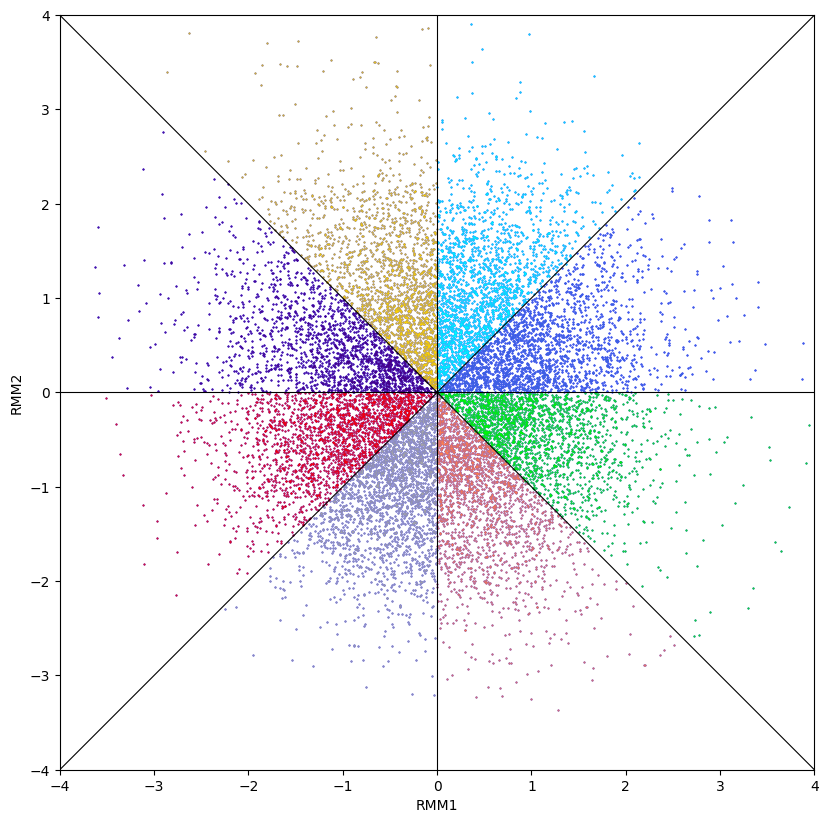

In [10]:
# plot MJO phases
Plot_MJO_phases(rmm1, rmm2, phase);


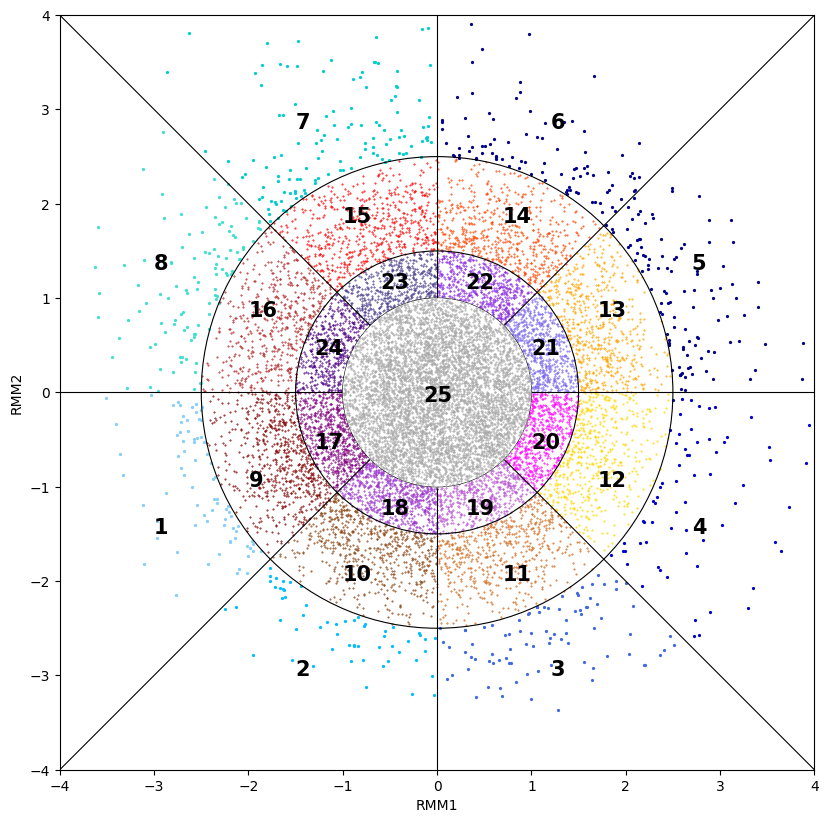

In [11]:
# plot MJO categories
Plot_MJO_Categories(rmm1, rmm2, categ);


In [12]:
MJO_hist = MJO_hist.sortby('time')

## **3. FIT THE AUTOREGRESSIVE LOGISTIC REGRESSION (ALR) MODEL WITH A MARKOV ORDER 3 AND SEASONALITY**


Synthetic time series of the MJO are obtained with a Markov chain of the predefined IWT categorical states (statistically significant to the third order) and subsequent sampling from joint distributions of IPC1 and IPC2 within each cluster. When consecutive days in the synthetic record are sampled from the same categorical state, the randomly picked EOF pairs are ordered to preserve counterclockwise propagation of the MJO around the globe in a consistent direction.

In [13]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

# MJO historical data for fitting
bmus_fit = xr.Dataset(
    {
        'bmus'  :(('time',), MJO_hist.categ.values[:]),
    },
    {'time' : MJO_hist.time.values[:]}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'seasonality': (True, alr_seasonality),
}

# ALR wrapper
ALRW = ALR_WRP(alr_path)
ALRW.SetFitData(25, bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=10000)



Fitting autoregressive logistic model ...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1896     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21888D+00    |proj g|=  3.47050D-01

At iterate    1    f=  2.64362D+00    |proj g|=  2.64530D-01

At iterate    2    f=  2.29776D+00    |proj g|=  2.10054D-01

At iterate    3    f=  2.07482D+00    |proj g|=  1.23478D-01

At iterate    4    f=  1.74400D+00    |proj g|=  1.51702D-01

At iterate    5    f=  1.56032D+00    |proj g|=  2.49467D-02

At iterate    6    f=  1.40454D+00    |proj g|=  2.04344D-02

At iterate    7    f=  1.23359D+00    |proj g|=  1.70956D-02

At iterate    8    f=  1.11180D+00    |proj g|=  1.61033D-02

At iterate    9    f=  1.06272D+00    |proj g|=  3.03918D-02

At iterate   10    f=  1.02720D+00    |proj g|=  7.06292D-03

At iterate   11    f=  1.00780D+00    |proj g|=  6.97810D-03

At iterate   12    f=  9.88352D-01    |proj g|=  8.42325D-03

At iterate   13    f=  9.7

In [14]:
## show fit report
# ALRW.Report_Fit()

---

## **4. TIME-SERIES SIMULATION OF *n* SIMULATIONS OF 1000 YEARS OF THE 25 CATEGORIES**


In [16]:
# -------------------------------------- 30 mins !!!
# Autoregressive Logistic Regression - simulate

# simulation dates
dates_sim = [d1_sim + timedelta(days=i) for i in range((d2_sim-d1_sim).days+1)]

# launch simulation
ALR_sim = ALRW.Simulate(num_sims, dates_sim)


ALR model fit   : 1980-01-01 --- 2023-04-03
ALR model sim   : 1900-01-01 --- 2000-01-01

Launching 100 simulations...

Sim. Num. 100: 100%|██████████| 36522/36522 [00:19<00:00, 1884.39it/s]



---

## **5. RANDOMLY OBTAIN PAIRS OF rmm1, rmm2 AND phase FROM THE SIMULATED TIME-SERIES**


In [18]:
# --------------------------------------
# MJO rmm1, rmm2, phase generation

# solve each ALR simulation
l_MJO_sim = []
for s in ALR_sim.n_sim:

    evbmus_sim = ALR_sim.sel(n_sim=s).evbmus_sims.values[:]

    # Generate rmm1 and rmm2 simulated values
    rmm12_sim = np.empty((len(evbmus_sim), 2)) * np.nan
    mjo_sim = np.empty(len(evbmus_sim)) * np.nan
    phase_sim = np.empty(len(evbmus_sim)) * np.nan

    categs = np.unique(evbmus_sim)
    for c in categs:
        c_ix = np.where(evbmus_sim==c)[0]

        # select random values for rmm1, rmm2
        options = d_rmm_categ['cat_{0}'.format(int(c))]
        r = np.random.randint(options.shape[0], size=len(c_ix))
        rmm12_sim[c_ix,:] = options[r,:]


    # calculate mjo and phase
    mjo_sim = np.sqrt(rmm12_sim[:,0]**2 + rmm12_sim[:,1]**2)
    phase_sim = np.arctan2(rmm12_sim[:,0], rmm12_sim[:,1])

    # internally reorder days with same category (counter-clockwise phase ascend)
    l_ad = GetRepeatedValues(evbmus_sim)
    for s,e in l_ad:

        # get sort index by MJO phase value
        ixs = np.argsort(phase_sim[s:e])

        # sort mjo
        rmm12_sim[s:e,0] = rmm12_sim[s:e,0][ixs]
        rmm12_sim[s:e,1] = rmm12_sim[s:e,1][ixs]
        mjo_sim[s:e] = mjo_sim[s:e][ixs]
        phase_sim[s:e] = phase_sim[s:e][ixs]


    # append simulated PCs
    l_MJO_sim.append(
        xr.Dataset(
            {
                'mjo'         :(('time',), mjo_sim),
                'phase'       :(('time',), phase_sim),
                'rmm1'        :(('time',), rmm12_sim[:,0]),
                'rmm2'        :(('time',), rmm12_sim[:,1]),
                'evbmus_sims' :(('time',), evbmus_sim),

            },
            {'time' : dates_sim}
        )
    )

# concatenate simulations
MJO_sim = xr.concat(l_MJO_sim, 'n_sim')

# store simulated MJO
save_nc(MJO_sim, mjo_sim_file, safe_time=True)


---



##  **6. VALIDATION**

Synthetic and historical MJO categories comparison:
- Perpetual Year
- Cluster Transition Probabilities

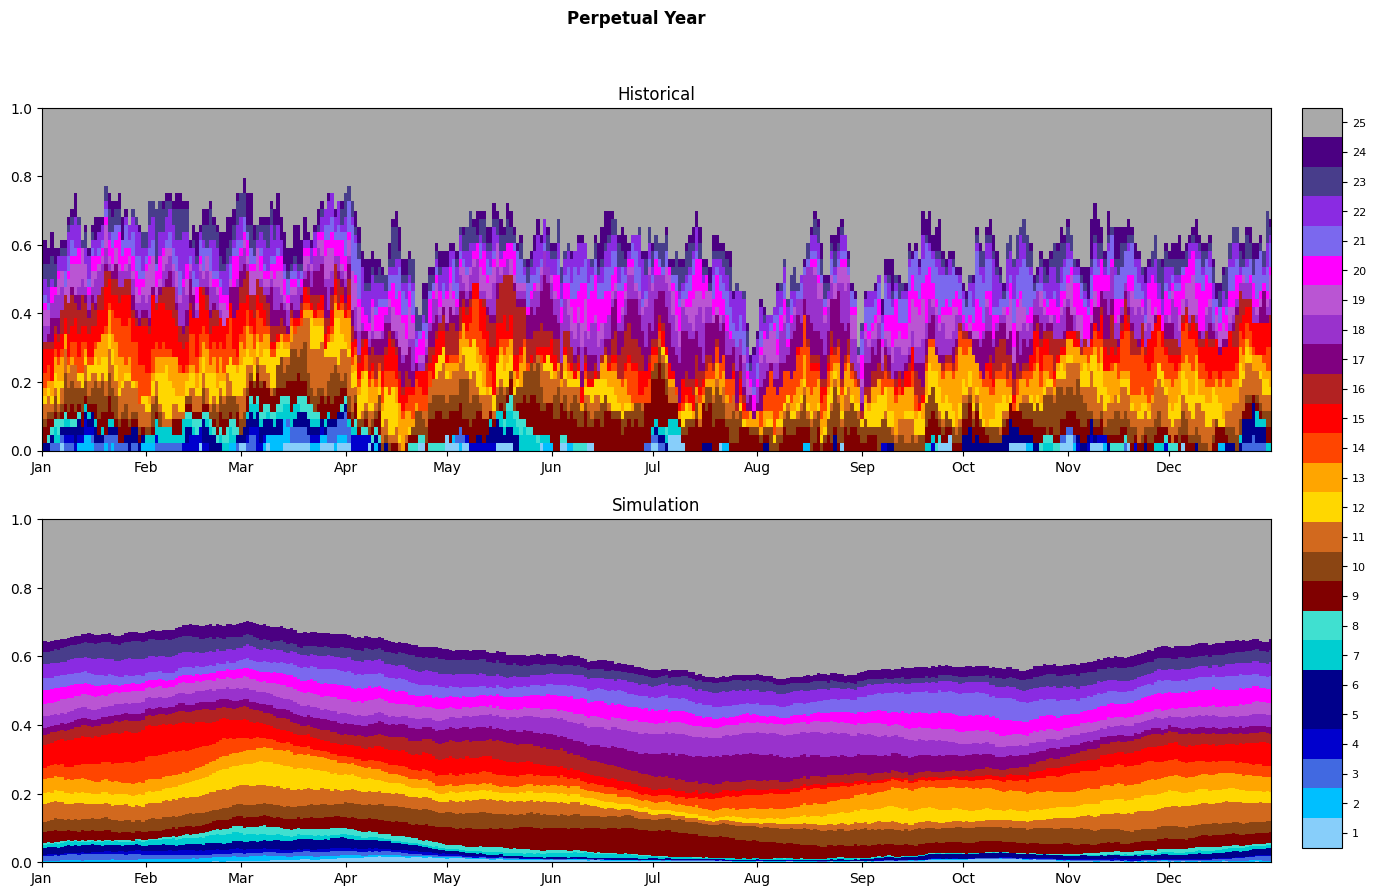

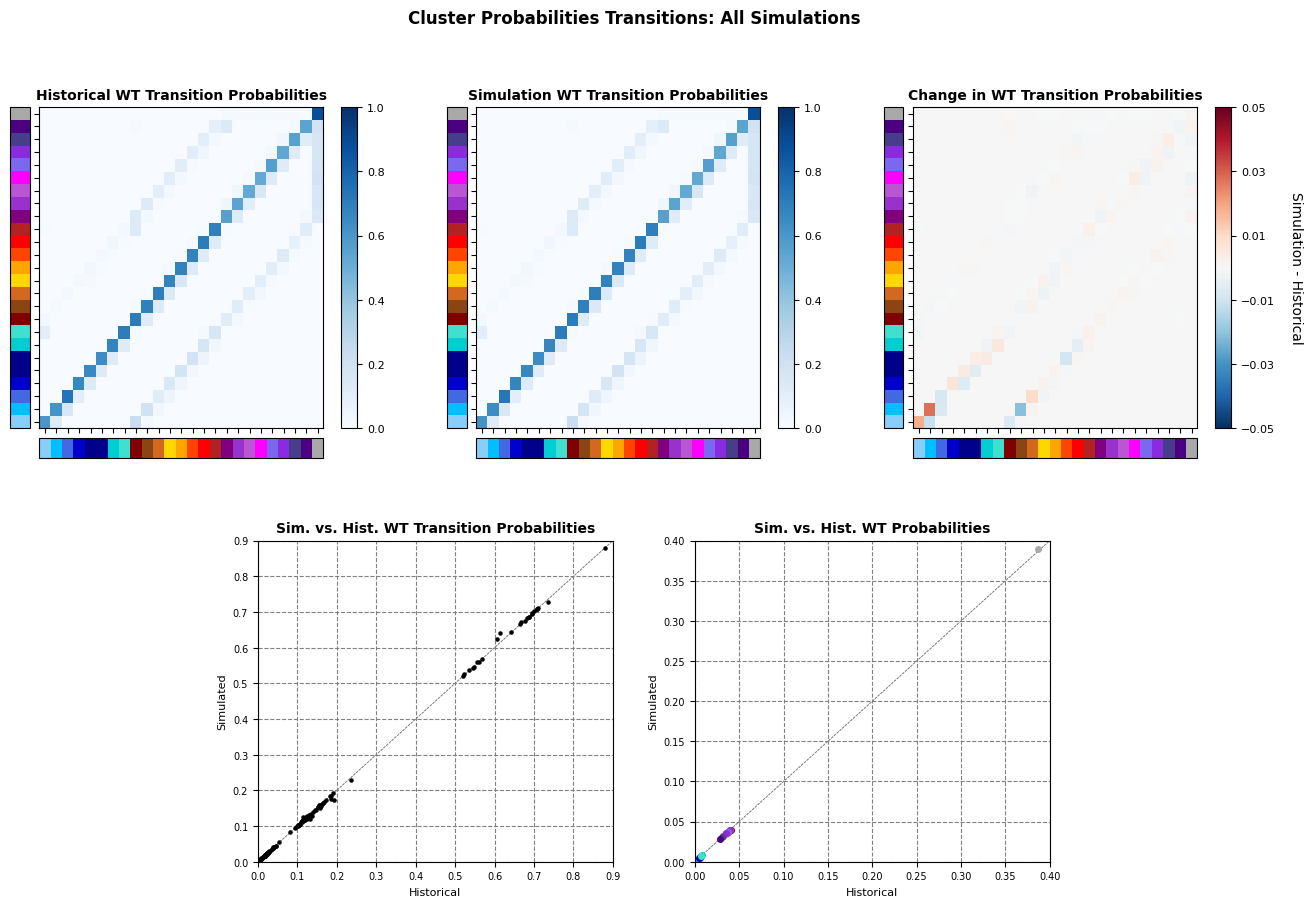

In [19]:
# show simulation report
ALRW.Report_Sim();


In [20]:
print(MJO_sim)

<xarray.Dataset> Size: 146MB
Dimensions:      (n_sim: 100, time: 36525)
Coordinates:
  * time         (time) object 292kB 1900-01-01 1900-01-02 ... 2000-01-01
Dimensions without coordinates: n_sim
Data variables:
    mjo          (n_sim, time) float64 29MB 0.1862 0.8282 0.6218 ... 1.411 1.333
    phase        (n_sim, time) float64 29MB -3.038 -2.05 ... -0.4565 -0.00523
    rmm1         (n_sim, time) float64 29MB -0.01928 -0.7348 ... -0.006969
    rmm2         (n_sim, time) float64 29MB -0.1852 -0.382 ... 1.266 1.333
    evbmus_sims  (n_sim, time) int64 29MB 25 25 25 25 25 22 ... 15 23 23 23 23
Attributes:
    source:   teslakit_v2.0
